### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from datetime import datetime
from glob import glob
from collections import Counter

%matplotlib inline

In [2]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
print(tf.__version__)
from keras.preprocessing import image

2.6.0


### Functions

In [45]:
def load_img(filepath,H=60,W=80):
    img = image.img_to_array(image.load_img(filepath, target_size=[H,W])).astype("uint8")
    return img

def to_grayscale(img):
    return img.mean(axis=-1)

def load_to_array(files,H,W,N):
    shape = (N,H,W)

    images = np.zeros(shape)
    for i, f in enumerate(files):
        img = to_grayscale(load_img(f))/255.
        images[i] = img

    return images

def labels_creator(N,files):
    labels = np.zeros(N)
    for i, f in enumerate(files):
        filename = f.rsplit("/", 1)[-1]
        subject_num = filename.split(".", 1)[0]

        idx = int(subject_num.replace("subject", "")) - 1
        labels[i] = idx

    return labels


def train_test_creation(n_train,n_test,images,files):
    img = images[0]

    train_images = np.zeros([n_train] + list(img.shape))
    train_labels = np.zeros(n_train)

    test_images = np.zeros([n_test] + list(img.shape))
    test_labels = np.zeros(n_test)

    count_so_far = {}
    train_idx = 0
    test_idx = 0
    for img, label in zip(images, labels):
        count_so_far[label] = count_so_far.get(label, 0) + 1

        if count_so_far[label] > 3:
            train_images[train_idx] = img
            train_labels[train_idx] = label
            train_idx += 1
        else:
            test_images[test_idx] = img
            test_labels[test_idx] = label
            test_idx += 1

    return train_images, test_images, train_labels, test_labels
            


def create_label_mappings(train_labels, test_labels):
    train_label2idx = {}
    test_label2idx = {}

    for i, label in enumerate(train_labels):
        if label not in train_label2idx:
            train_label2idx[label] = [i]
        else:
            train_label2idx[label].append(i)

    for i, label in enumerate(test_labels):
        if label not in test_label2idx:
            test_label2idx[label] = [i]
        else:
            test_label2idx[label].append(i)

    return train_label2idx, test_label2idx


def all_sample_indices(train_label2idx, test_label2idx):
    train_positives = []
    train_negatives = []
    test_positives = []
    test_negatives = []

    for label, indices in train_label2idx.items():
        other_indices = set(range(n_train)) - set(indices)

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                train_positives.append((idx1, idx2))
            for idx2 in other_indices:
                train_negatives.append((idx1, idx2))          

    for label, indices in test_label2idx.items():
        other_indices = set(range(n_test)) - set(indices)

        for i, idx1 in enumerate(indices):
            for idx2 in indices[i+1:]:
                test_positives.append((idx1, idx2))
            for idx2 in other_indices:
                test_negatives.append((idx1, idx2)) 

    return train_positives, train_negatives, test_positives, test_negatives


batch_size = 64

def train_generator(train_positives, train_negatives, H, W, train_images,batch_size):
    n_batches = int(np.ceil(len(train_positives)/batch_size))

    while True:
        np.random.shuffle(train_positives)
        n_samples = batch_size * 2
        shape = (n_samples, H, W)
        x_batch_1 = np.zeros(shape)
        x_batch_2 = np.zeros(shape)
        y_batch = np.zeros(n_samples)

        for i in range(n_batches):
            pos_batch_indices = train_positives[i * batch_size: (i+1) * batch_size]
            j=0
            for idx1, idx2 in pos_batch_indices:
                x_batch_1[j] = train_images[idx1]
                x_batch_2[j] = train_images[idx2]
                y_batch[j] = 1
                j += 1
            
            neg_indices = np.random.choice(len(train_negatives), size=len(pos_batch_indices), replace=False)
            for neg in neg_indices:
                idx1, idx2 = train_negatives[neg]
                x_batch_1[j] = train_images[idx1]
                x_batch_2[j] = train_images[idx2]
                y_batch[j] = 0
                j += 1  

            x1 = x_batch_1[:j]         
            x2 = x_batch_2[:j]
            y = y_batch[:j]

            x1 = x1.reshape(-1, 1, H, W)
            x2 = x2.reshape(-1, 1, H, W)

            x1 = torch.from_numpy(x1).float()
            x2 = torch.from_numpy(x2).float()
            y = torch.from_numpy(y).float()

            yield [x1,x2], y


def test_generator(test_positives, test_negatives, H, W, test_images,batch_size):
    n_batches = int(np.ceil(len(test_positives)/batch_size))

    while True:
        n_samples = batch_size * 2
        shape = (n_samples, H, W)
        x_batch_1 = np.zeros(shape)
        x_batch_2 = np.zeros(shape)
        y_batch = np.zeros(n_samples)

        for i in range(n_batches):
            pos_batch_indices = test_positives[i * batch_size: (i+1) * batch_size]
            j=0
            for idx1, idx2 in pos_batch_indices:
                x_batch_1[j] = test_images[idx1]
                x_batch_2[j] = test_images[idx2]
                y_batch[j] = 1
                j += 1

            neg_indices = np.random.choice(len(test_negatives), size=len(pos_batch_indices), replace=False)

            for neg in neg_indices:
                idx1, idx2 = test_negatives[neg]
                x_batch_1[j] = test_images[idx1]
                x_batch_2[j] = test_images[idx2]
                y_batch[j] = 0
                j += 1  

            x1 = x_batch_1[:j]         
            x2 = x_batch_2[:j]
            y = y_batch[:j]

            x1 = x1.reshape(-1, 1, H, W)
            x2 = x2.reshape(-1, 1, H, W)

            x1 = torch.from_numpy(x1).float()
            x2 = torch.from_numpy(x2).float()
            y = torch.from_numpy(y).float()

            yield [x1,x2], y


class SiameseNN(nn.Module):
    def __init__(self, feature_dim):
        super(SiameseNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),   

            nn.Flatten(),
            nn.Linear(13*18*64, 128), 
            nn.ReLU(),
            nn.Linear(128, feature_dim)
        )

    def forward(self, im1, im2):
        feat1 = self.cnn(im1)
        feat2 = self.cnn(im2)

        return torch.norm(feat1 - feat2, dim=-1)



def contrastive_loss(y, t):
    nonmatch = F.relu(1- y)
    return torch.mean(t* y**2 + (1-t) * nonmatch ** 2)


def create_model_and_train(test_positives, test_negatives,train_positives, train_negatives, H, W, test_images, train_images,train_steps_per_epoch,test_steps_per_epoch,batch_size=128,n_epochs=100):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model = SiameseNN(50)
    model.to(device)
    criterion = contrastive_loss
    optimizer = torch.optim.Adam(model.parameters())

    train_gen = train_generator(train_positives, train_negatives, H, W, train_images,batch_size)
    test_gen = test_generator(test_positives, test_negatives, H, W, test_images,batch_size)
        
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        steps = 0
        for (x1, x2), targets in train_gen:
            x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)

            optimizer.zero_grad()
            
            outputs = model(x1, x2)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())

            steps += 1
            if steps >= train_steps_per_epoch:
                break
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        steps = 0
        for (x1, x2), targets in test_gen:
            x1, x2, targets = x1.to(device), x2.to(device), targets.to(device)
            
            outputs = model(x1, x2)

            loss = criterion(outputs, targets)
                        
            test_loss.append(loss.item())
            steps += 1
            if steps >= test_steps_per_epoch:
                break
            
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it]  = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
        
    return model,train_losses, test_losses, device


def plot_metric(data, metric):
    plt.plot(data, label=metric)
    plt.legend()
    plt.show


def predict(x1, x2, model, device):
    x1 = torch.from_numpy(x1).float().to(device)
    x2 = torch.from_numpy(x2).float().to(device)

    with torch.no_grad():
        dist = model(x1, x2).cpu().numpy()
        return dist.flatten()


def get_accuracy(images, positives, negatives, H, W, model, device, threshold=0.85, batch_size=64):
    positive_distances = []
    negative_distances = []

    tp, tn, fp, fn = 0, 0, 0, 0
    x_batch_1 = np.zeros((batch_size, 1, H, W))
    x_batch_2 = np.zeros((batch_size, 1, H, W))
    n_batches = int(np.ceil(len(positives)/ batch_size))
    for i in range(n_batches):
        print(f"pos batch: {i+1}/{n_batches}")
        pos_batch_indices = positives[i * batch_size: (i+1) * batch_size]

        j = 0
        for idx1, idx2 in pos_batch_indices:
            x_batch_1[j, 0] = images[idx1]
            x_batch_2[j, 0] = images[idx2]
            j += 1

        x1 = x_batch_1[:j]
        x2 = x_batch_2[:j]
        distances = predict(x1, x2, model, device)
        positive_distances += distances.tolist()

        tp += (distances < threshold).sum()
        fn += (distances > threshold).sum()

    n_batches = int(np.ceil(len(negatives)/ batch_size))
    for i in range(n_batches):
        # print(f"pos batch: {i+1}/{n_batches}")
        neg_batch_indices = negatives[i * batch_size: (i+1) * batch_size]

        j = 0
        for idx1, idx2 in neg_batch_indices:
            x_batch_1[j, 0] = images[idx1]
            x_batch_2[j, 0] = images[idx2]
            j += 1

        x1 = x_batch_1[:j]
        x2 = x_batch_2[:j]
        distances = predict(x1, x2, model, device)
        negative_distances += distances.tolist()

        fp += (distances < threshold).sum()
        tn += (distances > threshold).sum() 

    tpr = tp / (tp+fn)   
    tnr = tn / (tn+fn)  

    print(f"senstivity (tpr): {tpr}, specificity (tnr): {tnr}")
    return positive_distances, negative_distances

### Load and Download Data

In [4]:
!wget -nc http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip

--2021-10-04 10:48:06--  http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
Resolving vision.ucsd.edu (vision.ucsd.edu)... 132.239.95.98
Connecting to vision.ucsd.edu (vision.ucsd.edu)|132.239.95.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6206308 (5.9M) [application/zip]
Saving to: ‘yalefaces.zip’

yalefaces.zip       100%[===================>]   5.92M   837KB/s    in 7.3s    

2021-10-04 10:48:13 (826 KB/s) - ‘yalefaces.zip’ saved [6206308/6206308]



In [5]:
!unzip yalefaces.zip

Archive:  yalefaces.zip
   creating: yalefaces/
  inflating: yalefaces/Readme.txt    
   creating: __MACOSX/
   creating: __MACOSX/yalefaces/
  inflating: __MACOSX/yalefaces/._Readme.txt  
  inflating: yalefaces/subject01.gif  
  inflating: yalefaces/subject01.glasses  
  inflating: yalefaces/subject01.glasses.gif  
  inflating: yalefaces/subject01.happy  
  inflating: yalefaces/subject01.leftlight  
  inflating: yalefaces/subject01.noglasses  
  inflating: yalefaces/subject01.normal  
  inflating: yalefaces/subject01.rightlight  
  inflating: yalefaces/subject01.sad  
  inflating: yalefaces/subject01.sleepy  
  inflating: yalefaces/subject01.surprised  
  inflating: yalefaces/subject01.wink  
  inflating: yalefaces/subject02.centerlight  
  inflating: yalefaces/subject02.glasses  
  inflating: yalefaces/subject02.happy  
  inflating: yalefaces/subject02.leftlight  
  inflating: yalefaces/subject02.noglasses  
  inflating: yalefaces/subject02.normal  
  inflating: yalefaces/subject02.r

In [6]:
files = glob("yalefaces/subject*")

In [7]:
np.random.shuffle(files)

In [8]:
N = len(files)
N

166

In [9]:
H, W = 60, 80
# load_img(files,H,W)

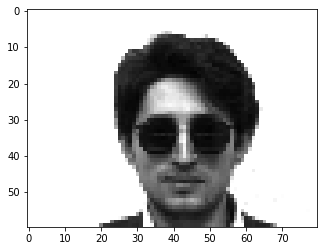

In [10]:
img = load_img(np.random.choice(files))
plt.imshow(img)
plt.show()

In [11]:
print(img.shape)
print(img.max())

(60, 80, 3)
255


In [12]:
np.all(img[:,:,0] == img[:,:,1]), np.all(img[:,:,0] == img[:,:,2])

(True, True)

In [13]:
images = load_to_array(files,H,W,N)

In [14]:
labels = labels_creator(N,files)

In [15]:
label_count = Counter(labels)
# print(label_count)
label_count

Counter({0.0: 12,
         1.0: 11,
         2.0: 11,
         3.0: 11,
         4.0: 11,
         5.0: 11,
         6.0: 11,
         7.0: 11,
         8.0: 11,
         9.0: 11,
         10.0: 11,
         11.0: 11,
         12.0: 11,
         13.0: 11,
         14.0: 11})

In [16]:
unique_labels = set(label_count.keys())

### Split data and indices creating

In [17]:
n_subjects = len(label_count)

n_test = 3 * n_subjects
n_train = N - n_test

In [18]:
train_images, test_images, train_labels, test_labels = train_test_creation(n_train,n_test,images,files)

In [19]:
train_label2idx, test_label2idx = create_label_mappings(train_labels, test_labels)

In [20]:
train_positives, train_negatives, test_positives, test_negatives = all_sample_indices(train_label2idx, test_label2idx)

### Create and Train model

In [21]:
train_steps = int(np.ceil(len(train_positives)/ batch_size))
test_steps = int(np.ceil(len(test_positives)/ batch_size))

In [22]:
model, train_losses, test_losses, device = create_model_and_train(test_positives, test_negatives,train_positives, train_negatives, H, W, test_images, train_images,train_steps,test_steps, batch_size = 64, n_epochs=20)

cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/20, Train Loss: 0.4357, Test Loss: 0.1710, Duration: 0:00:00.994208
Epoch 2/20, Train Loss: 0.1290, Test Loss: 0.1132, Duration: 0:00:00.599432
Epoch 3/20, Train Loss: 0.0772, Test Loss: 0.1063, Duration: 0:00:00.596810
Epoch 4/20, Train Loss: 0.0513, Test Loss: 0.0956, Duration: 0:00:00.592465
Epoch 5/20, Train Loss: 0.0352, Test Loss: 0.1063, Duration: 0:00:00.593278
Epoch 6/20, Train Loss: 0.0196, Test Loss: 0.0899, Duration: 0:00:00.594659
Epoch 7/20, Train Loss: 0.0168, Test Loss: 0.1182, Duration: 0:00:00.602634
Epoch 8/20, Train Loss: 0.0111, Test Loss: 0.1139, Duration: 0:00:00.593125
Epoch 9/20, Train Loss: 0.0062, Test Loss: 0.0984, Duration: 0:00:00.593703
Epoch 10/20, Train Loss: 0.0039, Test Loss: 0.1119, Duration: 0:00:00.594346
Epoch 11/20, Train Loss: 0.0028, Test Loss: 0.1136, Duration: 0:00:00.593478
Epoch 12/20, Train Loss: 0.0025, Test Loss: 0.1090, Duration: 0:00:00.593028
Epoch 13/20, Train Loss: 0.0020, Test Loss: 0.1296, Duration: 0:00:00.592946
Epoch 14

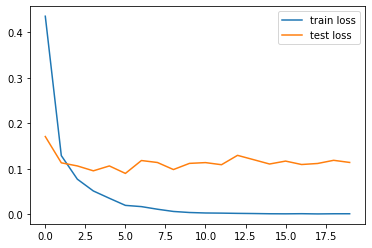

In [24]:
plot_metric(train_losses, "train loss")
plot_metric(test_losses, "test loss")

### Predict

In [61]:
threshold = 0.85

In [57]:
positive_distances, negative_distances = get_accuracy(train_images, train_positives, train_negatives, H, W, model, device, threshold=threshold, batch_size=64)

pos batch: 1/7
pos batch: 2/7
pos batch: 3/7
pos batch: 4/7
pos batch: 5/7
pos batch: 6/7
pos batch: 7/7
senstivity (tpr): 1.0, specificity (tnr): 1.0


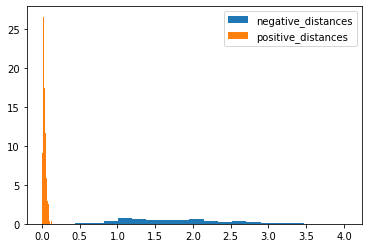

In [58]:
plt.hist(negative_distances, bins=20, density=True, label="negative_distances")
plt.hist(positive_distances, bins=20, density=True, label="positive_distances")

plt.legend()
plt.show()

In [59]:
positive_distances, negative_distances = get_accuracy(test_images, test_positives, test_negatives, H, W, model, device, threshold=threshold, batch_size=64)

pos batch: 1/1
senstivity (tpr): 0.6666666666666666, specificity (tnr): 0.9920212765957447


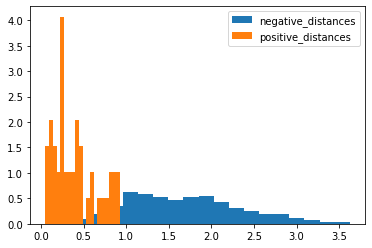

In [60]:
plt.hist(negative_distances, bins=20, density=True, label="negative_distances")
plt.hist(positive_distances, bins=20, density=True, label="positive_distances")

plt.legend()
plt.show()